In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn import metrics
import sklearn

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

PATH_TO_DATA = "../data"
PATH_TO_MODELS = "models"
PATH_TO_OUTPUT = "output"

/home/tyuzhakov/vshokorov/my_tests/vsh_env/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
input_data = pd.read_csv(os.path.join(PATH_TO_DATA,"polock_dataset_train.csv"), index_col='Unnamed: 0', parse_dates=['datetimes'])
input_data['velocity'].fillna(0, inplace=True)
input_data['course'].fillna(0, inplace=True)

In [4]:
input_data

,idves,date,datetimes,idinf,latitude,longitude,region,course,velocity,ton,total_ton,trawl,science
0,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29 00:00:00,2003-01-29 00:48:00,52,54.330700,154.108000,274,350.0,4.0,0.000000,71.900200,трал р/гл не зарегистрированный НПО ПР,0
1,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29 00:00:00,2003-01-29 01:22:00,32,54.368700,154.098700,274,351.0,4.0,0.000000,71.900200,трал р/гл не зарегистрированный НПО ПР,0
2,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29 00:00:00,2003-01-29 02:14:00,52,54.426000,154.099300,274,6.0,4.0,0.000000,71.900200,трал р/гл не зарегистрированный НПО ПР,0
3,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29 00:00:00,2003-01-29 03:24:00,52,54.484000,154.118700,274,186.0,5.0,6.389573,71.900200,трал р/гл не зарегистрированный НПО ПР,0
4,cc2b1ba0368ccd98d5bed7e2e97b4bb0,2003-01-29 00:00:00,2003-01-29 04:38:00,52,54.400700,154.093300,274,184.0,4.0,19.701184,71.900200,трал р/гл не зарегистрированный НПО ПР,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98076,c76e4b2fa54f8506719a5c0dc14c2eb9,2021-04-29 00:00:00,2021-04-29 23:12:55,1035,57.007402,153.833533,274,267.0,10.0,0.000000,4.032845,научное (экспериментальное) орудие добычи (выл...,1
98077,c76e4b2fa54f8506719a5c0dc14c2eb9,2021-04-29 00:00:00,2021-04-29 23:25:35,1035,57.006667,153.768333,274,270.0,10.0,0.000000,4.032845,научное (экспериментальное) орудие добычи (выл...,1
98078,c76e4b2fa54f8506719a5c0dc14c2eb9,2021-04-29 00:00:00,2021-04-29 23:34:28,1035,57.005000,153.720000,274,267.0,9.0,0.000000,4.032845,научное (экспериментальное) орудие добычи (выл...,1
98079,c76e4b2fa54f8506719a5c0dc14c2eb9,2021-04-29 00:00:00,2021-04-29 23:37:04,1035,57.004985,153.706693,274,267.0,10.0,0.000000,4.032845,научное (экспериментальное) орудие добычи (выл...,1


In [5]:
TRAIN_CLASSIFICATION = True
TRAWL_EMB_DIM = 15
MONTH_EMB_DIM = 15
trawl_to_id = {name: i for i, name in enumerate(input_data.trawl.unique())}

def df_to_numpy(df):
    df = df.sort_values('date').reset_index(drop=True)
    times = df.datetimes.apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second).to_numpy()

    # static values
    X_init = {'input': []}
    total_ton = df.total_ton.mean()
    X_init['input'].append(total_ton)
    X_init['input'].append(total_ton / len(df)) # ton_div_points
    X_init['input'].append(total_ton / (df.datetimes.max() - df.datetimes.min()).seconds) # ton_div_total_time
    X_init['input'].append(times[0]) # init day_time
    
    X_init['trawl'] = trawl_to_id[df.trawl.unique()[0]]


    latitude_diff  = np.diff(df['latitude' ].to_numpy(), prepend=df['latitude' ][0])
    longitude_diff = np.diff(df['longitude'].to_numpy(), prepend=df['longitude'][0])
    total_dist = np.sum(np.sqrt(latitude_diff**2 + longitude_diff**2))
    X_init['input'].append(total_dist)
    X_init['input'].append(total_ton / total_dist) # ton_div_total_dist

    X_init['input'] = np.nan_to_num(X_init['input'], neginf=0, posinf=0)


    X_init['month'] = df.datetimes.min().month - 1
    X_init['next_month'] = df.datetimes.min().month % 12
    X_init['month_percent'] = df.datetimes.min().day / 31

    # dynamic values
    X_train = [df[[
        'latitude',
        'longitude',
        'velocity', 
        'science', 
        ]].to_numpy().copy()]
    

    dx = df['velocity'].to_numpy() * np.cos(df['velocity'].to_numpy() * np.pi / 180)
    dy = df['velocity'].to_numpy() * np.sin(df['velocity'].to_numpy() * np.pi / 180)
    X_train.append(dx[:, None])
    X_train.append(dy[:, None])



    times_diff = np.diff(times, prepend=times[0])
    X_train.append(total_ton / times_diff[:, None]) # ton_div_prev_time
    X_train.append(total_ton / df.velocity.to_numpy()[:, None]) # ton_div_velocity
    X_train.append(latitude_diff[:, None])
    X_train.append(longitude_diff[:, None])

    X_train = np.hstack(X_train)
    np.nan_to_num(X_train, neginf=0, posinf=0, copy=False) 
    
    return X_init, X_train, df.ton.to_numpy().copy()

data_list_train = []
data_list_val = []
target_ids = pd.read_csv(os.path.join(PATH_TO_DATA,"val.csv"))['Unnamed: 0.1'].to_numpy()

uniq_trips = input_data.groupby(['idves','date', 'trawl']).size().reset_index().rename(columns={0:'count'})
for _, raw in uniq_trips.iterrows():
    df_mask = (
        (input_data.idves == raw['idves']) &
        (input_data.date == raw['date']) &
        (input_data.trawl == raw['trawl'])
    )
    df = input_data[df_mask]

    __info = df_to_numpy(df)

    df_info = __info[0]
    df_info['input'] = torch.from_numpy(df_info['input'][None]).float().cuda()
    df_info['x'] = torch.from_numpy(__info[1]).float().cuda()
    
    if TRAIN_CLASSIFICATION:
        df_info['y'] = torch.from_numpy(__info[2] > 0.3392).long().cuda()
    else:
        df_info['y'] = torch.from_numpy(__info[2]).float().cuda()

    if np.isin(df.index, target_ids).any():
        assert np.isin(df.index, target_ids).all()
        data_list_val.append(df_info)
    else:
        data_list_train.append(df_info)

for part in ['x', 'input']:
    x = torch.cat([i[part] for i in data_list_train])

    mean = x.mean(0, keepdim=True)
    std = x.std(0, keepdim=True)

    for l in [data_list_val, data_list_train]:
        for i in l:
            i[part].sub_(mean)
            i[part].div_(std)


for l in [data_list_val, data_list_train]:
    for i in l:
        for part in ['trawl', 'month', 'next_month']:
            i[part] = torch.tensor([i[part]], device='cuda')

divide by zero encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


In [7]:
HIDDEN_SIZE = 10

class LSTMRegressor(nn.Module):
    def __init__(self, tagset_size=1):
        super(LSTMRegressor, self).__init__()

        self.trawl_hash = nn.Embedding(len(trawl_to_id), TRAWL_EMB_DIM)
        self.month_hash = nn.Embedding(12, MONTH_EMB_DIM)

        self.lstm = nn.LSTM(
            input_size = data_list_train[0]['x'].size(1), 
            hidden_size = HIDDEN_SIZE,
            batch_first=False,
            bidirectional=True,
            num_layers = 1
        )

        self.last_projector = nn.Linear(2 * HIDDEN_SIZE, tagset_size)
        self.first_projector = nn.Linear(TRAWL_EMB_DIM+MONTH_EMB_DIM+6, HIDDEN_SIZE)
        self.sigmoid = nn.Sigmoid()

    def forward(self, trawl, months, mpercent, input, seq):
        trawl  = self.trawl_hash(trawl)
        months = (self.month_hash(months[0]) * (1 - mpercent) + self.month_hash(months[1]) * mpercent)

        input = torch.cat([trawl, months, input], dim=1)
        c = torch.sigmoid(self.first_projector(input))[None].repeat(2, 1, 1)
        lstm_out, _ = self.lstm(seq.view(len(seq), 1, -1), (torch.zeros_like(c), c))

        out = self.last_projector(lstm_out.view(len(seq), -1))
        # tag_scores = F.log_softmax(tag_space, dim=1)
        return out

In [7]:
if TRAIN_CLASSIFICATION:
    lstm = LSTMRegressor(tagset_size=2).cuda()
    loss_function = nn.CrossEntropyLoss()
    max_lr = 1e-3
else:
    lstm = LSTMRegressor(tagset_size=1).cuda()
    loss_function = nn.MSELoss()
    max_lr = 1e-3

epochs = 100
optimizer = torch.optim.SGD(lstm.parameters(), lr=0, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=epochs * len(data_list_train))

In [28]:
res = []
res_val = []
for epoch in tqdm(range(epochs)):
    lstm.train()
    res.append([])

    for x in data_list_train:
        optimizer.zero_grad()

        out = lstm(
            x['trawl'], 
            [x['month'], x['next_month']], 
            x['month_percent'], 
            x['input'], 
            x['x'])

        loss = loss_function(out, x['y'])
        loss.backward()
        res[-1].append(loss.item())
    
        optimizer.step()
        lr_scheduler.step()
    
    if epoch % 5 != 4:
        continue
    
    with torch.no_grad():
        lstm.eval()
        res_val.append([])
        for x in data_list_val:
            out = lstm(
                x['trawl'], 
                [x['month'], x['next_month']], 
                x['month_percent'], 
                x['input'], 
                x['x'])

            loss = loss_function(out, x['y'])
            res_val[-1].append(loss.item())

100%|██████████| 100/100 [18:13<00:00, 10.93s/it]


In [3]:
res = np.load('res_class.npy')
res_val = np.load('res_val_class.npy')

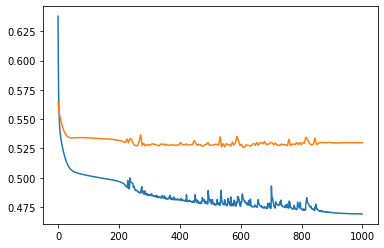

In [4]:
plt.plot([np.mean(i) for i in res])
plt.plot(np.linspace(0, len(res), len(res_val)), [np.mean(i) for i in res_val])

0.8073584662252169 0.8214441758504005


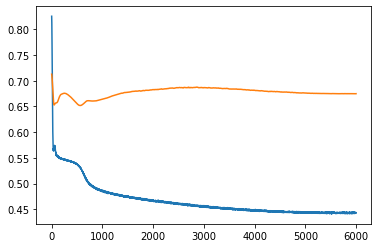

In [35]:
# выбирай какой тебе больше нравится
plt.plot(res)
plt.plot(res_val)
# plt.ylim(0, 20)
print(np.sqrt(min(res_val)), np.sqrt(res_val[-1]))

In [10]:
lstm.eval()

y_train = []
y_pred = []

with torch.no_grad():
    for x in data_list_train:
        out = lstm(
            x['trawl'], 
            [x['month'], x['next_month']], 
            x['month_percent'], 
            x['input'], 
            x['x'])
        
        y_train.append(x['y'].cpu().numpy())
        y_pred.append(F.softmax(out, dim=1).cpu().numpy()[:, 1])
    
y_train = np.concatenate(y_train)
y_pred = np.concatenate(y_pred)

y_val = []
y_pred_val = []

with torch.no_grad():
    for x in data_list_val:
        out = lstm(
            x['trawl'], 
            [x['month'], x['next_month']], 
            x['month_percent'], 
            x['input'], 
            x['x'])
        
        y_val.append(x['y'].cpu().numpy())
        y_pred_val.append(F.softmax(out, dim=1).cpu().numpy()[:, 1])
    
y_val = np.concatenate(y_val)
y_pred_val = np.concatenate(y_pred_val)

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

print(metrics.confusion_matrix(y_train, y_pred > thresholds[ix])) # tn, fp, fn, tp
print(metrics.accuracy_score(y_train, y_pred > thresholds[ix]))
print(metrics.accuracy_score(y_val, y_pred_val > thresholds[ix]))

Best Threshold=0.275559, G-Mean=0.696
[[33141 15953]
 [ 4211 10730]]
0.6851097056297337
0.6023840791999192
